In [288]:
import os

In [289]:
os.getcwd()

'/home/wenjie/Downloads'

In [290]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append('./lstm/')
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler


In [291]:
#read data
data = np.load('npt_trajectory_sorted.npz')

In [292]:
data['arr_0'].shape

(171, 100000, 11)

In [293]:
# extract one time serie sequence
atom_1_vx=data['arr_0'][1,:,5]


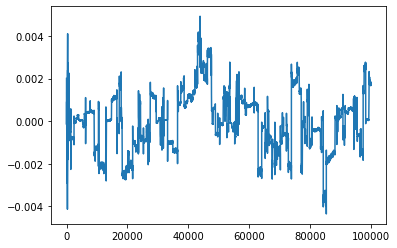

In [295]:
plt.plot(np.arange(0, len(atom_1_vx)),atom_1_pos_vx)

In [296]:
#generate training tuples
def sequence2dataset(seq, window):
    data_seq=[]
    label_seq = []
    for i in range(0,len(seq)-window):
        data = seq[i:i+window]
        label = seq[i+window]
        data_seq.append(data)
        label_seq.append(label)
        
    return data_seq, label_seq
        

In [297]:
train_size = int(len(atom_1_pos_vx)*0.8)
window = 100

In [299]:
#rescale data and generate data list from tuples

scaler = MinMaxScaler(feature_range=(-1, 1))
transformed_atom_1_vx = scaler.fit_transform(atom_1_vx.reshape(-1,1))

train_data_list, train_label_list= sequence2dataset(transformed_atom_1_vx[0:train_size],100)
test_data_list, test_label_list= sequence2dataset(transformed_atom_1_vx[train_size:],100)

In [303]:
print(len(train_data_list))
print(len(test_data_list))

79900
19900


In [304]:
#generate dataset and dataloader from data list

train_dataset = TensorDataset(torch.Tensor(train_data_list),torch.Tensor(train_label_list))
train_dataloader = DataLoader(train_dataset,batch_size = 128, shuffle = True)
test_dataset = TensorDataset(torch.Tensor(test_data_list),torch.Tensor(test_label_list))
test_dataloader = DataLoader(test_dataset,batch_size = 128, shuffle = False)

In [306]:
# my model, a single LSTM unit

class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(RNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size1)
        self.lstm = torch.nn.LSTM(hidden_size1, hidden_size2, dropout=0.2)
        
        self.fc2 = torch.nn.Linear(hidden_size2, output_size)
        
    def forward(self, input):
        x = self.fc1(input)
        _, (h, _) = self.lstm(x)
        
        return self.fc2(h)
    
        
        
        
        

In [307]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNN(1,8,16,1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = torch.nn.MSELoss()

/home/wenjie/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [308]:
model

RNN(
  (fc1): Linear(in_features=1, out_features=8, bias=True)
  (lstm): LSTM(8, 16, dropout=0.2)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

In [310]:
#train, for each 10 epochs, run the test dataset
epochs = 1000
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_dataloader:
        optimizer.zero_grad()
        x = x.transpose(0,1)
        x=x.to(device)
        y=y.to(device)
        pred= model(x)
        pred = pred.squeeze(0)
        
        loss = criterion(pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
        optimizer.step()
        total_loss += loss
        
    print('current epoch is {:3d}, erros is {:5f}'.format(epoch, total_loss))
    
    if epoch%10 == 0:
        model.train()
        with torch.no_grad():
            test_loss = 0
            for x, y in test_dataloader:
                x = x.transpose(0,1)
                x=x.to(device)
                y=y.to(device)
                pred= model(x)
                pred = pred.squeeze(0)

                loss = criterion(pred, y)
                
                test_loss +=loss
        
        print('current epoch is {:3d}, test erros is {:5f}'.format(epoch, test_loss))


    

current epoch is   0, erros is 0.008293
current epoch is   0, test erros is 0.001607
current epoch is   1, erros is 0.007181
current epoch is   2, erros is 0.006201
current epoch is   3, erros is 0.005343
current epoch is   4, erros is 0.005121
current epoch is   5, erros is 0.004240
current epoch is   6, erros is 0.003778
current epoch is   7, erros is 0.003579
current epoch is   8, erros is 0.003470
current epoch is   9, erros is 0.003218
current epoch is  10, erros is 0.003225
current epoch is  10, test erros is 0.002114
current epoch is  11, erros is 0.003082
current epoch is  12, erros is 0.002831
current epoch is  13, erros is 0.002676
current epoch is  14, erros is 0.002616
current epoch is  15, erros is 0.002338
current epoch is  16, erros is 0.002174
current epoch is  17, erros is 0.002215
current epoch is  18, erros is 0.002097
current epoch is  19, erros is 0.002027
current epoch is  20, erros is 0.001844
current epoch is  20, test erros is 0.000819
current epoch is  21, err

KeyboardInterrupt: 

In [311]:
#try to predict

def pred2seq(pred, oldseq):
    '''
    accept the old seq and new prediction based on old seq, return a new seq for next prediciton
    '''
    seq = torch.cat((oldseq,pred), 0)
    
    return seq[1:]

model.eval()
sequence = torch.Tensor(transformed_atom_1_vx[:10]).unsqueeze(0).transpose(0,1).to(device)
pred_list = []
with torch.no_grad():
    for i in range(100000-train_size):
        pred = model(sequence)
        pred_list.append(pred.cpu().squeeze(0).numpy())

        sequence = pred2seq(pred, sequence)

    

In [315]:
output = [scaler.inverse_transform(pred).squeeze(0) for pred in pred_list]

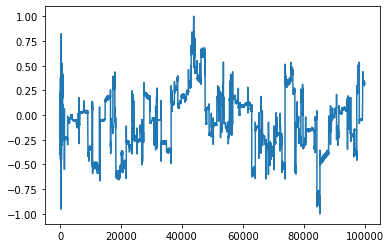

In [318]:
# plot the whole ground truth data
plt.plot(transformed_atom_1_vx)

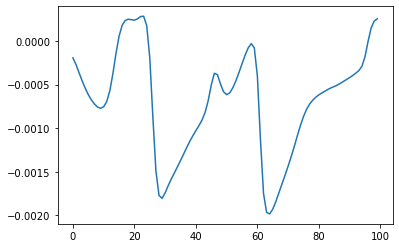

In [326]:
#plot the ground truth data for first 100 step predictions
plt.plot(atom_1_vx[100:200])

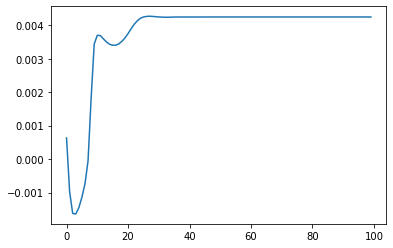

In [324]:
# plot the prediction data for first 100 steps
plt.plot(output[:100])

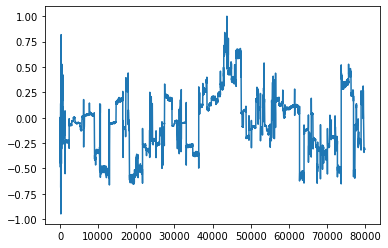

In [341]:
#same test procedure as train_LSTM.py
inputseq = torch.Tensor(train_data_list).transpose(0,1)
pred = model(inputseq.to(device))
pred = pred.detach().cpu().numpy().squeeze(0)
plt.plot(pred)

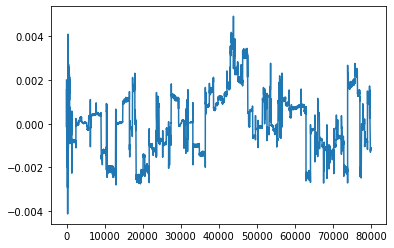

In [339]:
#ground truth data
plt.plot(atom_1_vx[0:80000])